In [143]:
import numpy as np
import pandas as pd
import util
import ml_alg
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import time
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime,timedelta
from  sklearn.model_selection import GridSearchCV
import pickle
%matplotlib inline

In [2]:
train_path = 'dataSets/training/'
test_path = "dataSets/testing_phase1/"
data_path = "dataSets/data/"

In [164]:
def g_data(moment_id1, moment_id2, moment_id3, tollgate_id, direction):
    train_df = pd.read_csv(train_path + 'data_' + str(tollgate_id) + '_' + str(direction) + '_final.csv', index_col=0)
    test_df = pd.read_csv(test_path + 'data_' + str(tollgate_id) + '_' + str(direction) + '_final.csv', index_col=0)
    train_df.drop(['volume'], axis=1, inplace=True)
    test_df.drop(['volume'], axis=1, inplace=True)
    sLength1 = len(train_df)
    sLength2 = len(test_df)
    train_df = train_df.assign(e=pd.Series(np.zeros(sLength1)).values)
    test_df = test_df.assign(e=pd.Series(np.ones(sLength2)).values)
    
    test_df2 = test_df.ix[['2016-10-18 ' + moment_id1, '2016-10-19 ' + moment_id1,  '2016-10-20 ' + moment_id1,  '2016-10-21 ' + moment_id1,  '2016-10-22 ' + moment_id1,  '2016-10-23 ' + moment_id1,  '2016-10-24 ' + moment_id1, '2016-10-18 ' + moment_id2, '2016-10-19 ' + moment_id2, '2016-10-20 ' + moment_id2, '2016-10-21 ' + moment_id2, '2016-10-22 ' + moment_id2, '2016-10-23 ' + moment_id2, '2016-10-24 ' + moment_id2]]
    train_df2 = train_df.ix[moment_id3:]

    all_df = pd.concat((train_df2, test_df2), axis=0)
    dweek = pd.get_dummies(all_df['dayofweek'], prefix='dayofweek')
    dhour = pd.get_dummies(all_df['hour'], prefix='hour')
    numeric_cols = all_df.columns[all_df.dtypes != 'object']
    numeric_cols = numeric_cols.values[:-1]
    numeric_col_means = all_df.loc[:, numeric_cols].mean()
    numeric_col_std = all_df.loc[:, numeric_cols].std(ddof=0)
    all_df.loc[:, numeric_cols] = (all_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std
    all_df.drop(['hour'], axis=1, inplace=True)
    all_df.drop(['dayofweek'], axis=1, inplace=True)
    all_df = pd.concat([all_df, dweek, dhour], axis=1)
    all_df = all_df.dropna(axis=1)
    #dummy_train_df_1 = all_df.loc[train_df2.index]
    #dummy_test_df = all_df.loc[test_df2.index]
    y_train = all_df.pop('e').values
    #y_test = test_df2.pop('e').values
    #X_train = dummy_train_df_1.values
    X_train = all_df.values
    #X_test = dummy_test_df.values
    
    
    return X_train,y_train

In [165]:
X_train, y_train = g_data('08:00:00', '17:00:00', '2016-09-19 02:00:00', 1, 0)

In [166]:
y_train

array([ 0.,  0.,  0., ...,  1.,  1.,  1.])

In [111]:
from sklearn.linear_model import LogisticRegression
y_train
clf = LogisticRegression(class_weight =  'balanced', random_state = 42, n_jobs = -1)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [118]:
pred_prob = clf.predict_proba(X_train)

In [119]:
pred.argmax()

190

In [120]:
pred.mean()

0.5

In [121]:
pred = clf.predict(X_train)

In [122]:
pred

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [123]:
pred[pred == 1].sum()

15.0

In [130]:
weight = pred_prob[:, 1]/pred_prob[:, 0]
print(weight)

[  8.56342220e-04   1.56144377e-03   2.69919060e-04 ...,   1.39062856e+02
   3.28522182e+02   2.97850637e+02]


In [132]:
weight[:-15].mean()

0.0099757903388474952

In [129]:
pred_prob

array([[  9.99144390e-01,   8.55609525e-04],
       [  9.98440991e-01,   1.55900947e-03],
       [  9.99730154e-01,   2.69846224e-04],
       ..., 
       [  7.13965165e-03,   9.92860348e-01],
       [  3.03469707e-03,   9.96965303e-01],
       [  3.34615315e-03,   9.96653847e-01]])

In [137]:
(weight[:-15]>0.5).sum()

3

In [148]:
a = weight[:-14]

In [149]:
a = pd.Series(a)

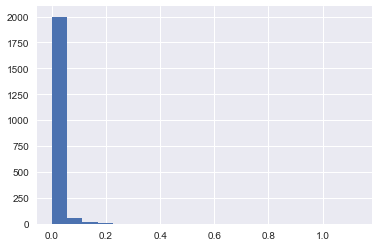

In [150]:
a.hist(bins = 20)

In [147]:
weight[-14:]

array([ 253.99893239,  219.15960969,  780.89553524,  443.77653072,
        294.1621533 ,  249.61585185,  228.7926342 ,  145.23186868,
        163.49373891,  238.89153956,  201.43018356,  139.06285581,
        328.52218172,  297.85063679])

In [151]:
from xgboost import XGBClassifier

/Users/Solomon/anaconda3/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [154]:
clf2 = XGBClassifier(n_estimators = 1000, seed = 42, weights)
clf2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [155]:
pred_prob2 = clf2.predict_proba(X_train)

In [157]:
pred_prob2 = clf2.predict_proba(X_train)
weight2 = pred_prob2[:, 1]/pred_prob[:, 0]
print(weight2)

[  1.59991192e-04   9.12316907e-05   6.09512792e-05 ...,   1.21176345e+02
   2.94091117e+02   2.75692406e+02]


In [195]:
weight2[:-14].shape

(2082,)

In [168]:
y_train = y_train.astype('int64')
(2082+14) / (2 * np.bincount(y_train))

array([  0.50336215,  74.85714286])

In [161]:
y_train

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [169]:
sample_weight = np.ones(2082) * 0.50336215

In [170]:
sample_weight2 = np.ones(14) * 74.85714286

In [174]:
sample_weight = np.concatenate((sample_weight, sample_weight2))

In [177]:
sample_weight[-14:]

array([ 74.85714286,  74.85714286,  74.85714286,  74.85714286,
        74.85714286,  74.85714286,  74.85714286,  74.85714286,
        74.85714286,  74.85714286,  74.85714286,  74.85714286,
        74.85714286,  74.85714286])

In [179]:
clf2 = XGBClassifier(n_estimators = 1000, seed = 42)
clf2.fit(X_train, y_train, sample_weight = sample_weight)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [188]:
pred_prob2 = clf2.predict_proba(X_train)
weight2 = pred_prob2[:, 1]/pred_prob2[:, 0]
print(weight2)

[  1.61607051e-04   9.86420055e-05   7.57052767e-05 ...,   6.51276978e+02
   7.98981689e+02   1.22621204e+03]


In [189]:
b = weight2[:-14] 

In [190]:
b = pd.Series(b)

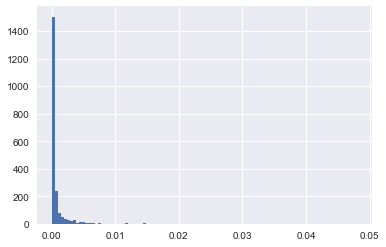

In [191]:
b.hist(bins = 100)

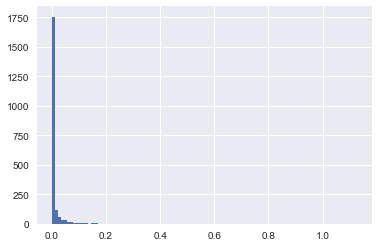

In [192]:
a.hist(bins = 100)

In [193]:
b.mean()

0.0009687242563813925

In [194]:
a.mean()

0.009971321587968299